In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster, HeatMap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
realestatedata = pd.read_csv("HousingPricePredCapstoneProject2.csv",index_col=0)

# Data Cleansing

Kings County Real Estate Agency has recently entered the Seattle housing market to assist potential homebuyers with finding they're ideal household. For being so new to the Seattle housing market, Kings County Real Estate Agency needs to find a reliable tool to use for predicting house prices, helping to provide accurate and truthful prices for potential homebuyers. Through past recorded house information we can evaluate several household factors with relation to the latest resale price to gain an understanding of what factors effect the price.

## Factors to Analyze

### House Condition


The conditions of a household may hold an influence on the price. Within the acquired dataset, house condition is scaled from 1 - 5, 5 being the best condition. Factors such as resale price, year built, year of renovation and grade (1 - 13) can give support as to how the house condition is scaled.

### Floor Plan


A floor plan is a huge portion to determining a households value. Factors such as total square footage, total floors, number of bedrooms and bathrooms as well as property square footage can provide valuable insight.

### Location

Location may also determine how expensive or inexpensive a household can be. Whether a house is on the waterfront(0 or 1) or has a good view (1-4, amount of views) may play a part in that price. Looking into the zip code of each household may provide a pattern for how price differs, providing more insight as to location being a valuable factor.

# Insights


Within the housing dataset the column for resale dates, 'date', held improper formating resulting in every value to appear as '20141013T000000'. I wish to change this immediately to a 'YYYY-MM-DD' format to allow me to use this information properly. To acheive this I must use pandas operation '.to_datetime' as you see below.

In [3]:
realestatedata['date'] = pd.to_datetime(realestatedata['date'].str[:8], format='%Y%m%d')
realestatedata.head()


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
realestatedata.dtypes

date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [5]:
#Size of the data frame (rows, columns)
realestatedata.shape

(21613, 20)

In [6]:
# Checking data for precaution missing data
def print_null(data):
    null_count = data.isna().sum()
    null_percent = data.isna().sum() / len(data)
    null_percent = null_percent.apply(lambda x: f"{x:.1%}")
    print("Total duplicated data: ", data.duplicated().sum())
    result = pd.concat([null_count, null_percent], axis=1)
    result.columns = ['Null Data Count', 'Null Percentage']
    return result
print_null(realestatedata)

Total duplicated data:  0


,Null Data Count,Null Percentage
date,0,0.0%
price,0,0.0%
bedrooms,0,0.0%
bathrooms,0,0.0%
sqft_living,0,0.0%
sqft_lot,0,0.0%
floors,0,0.0%
waterfront,0,0.0%
view,0,0.0%
condition,0,0.0%


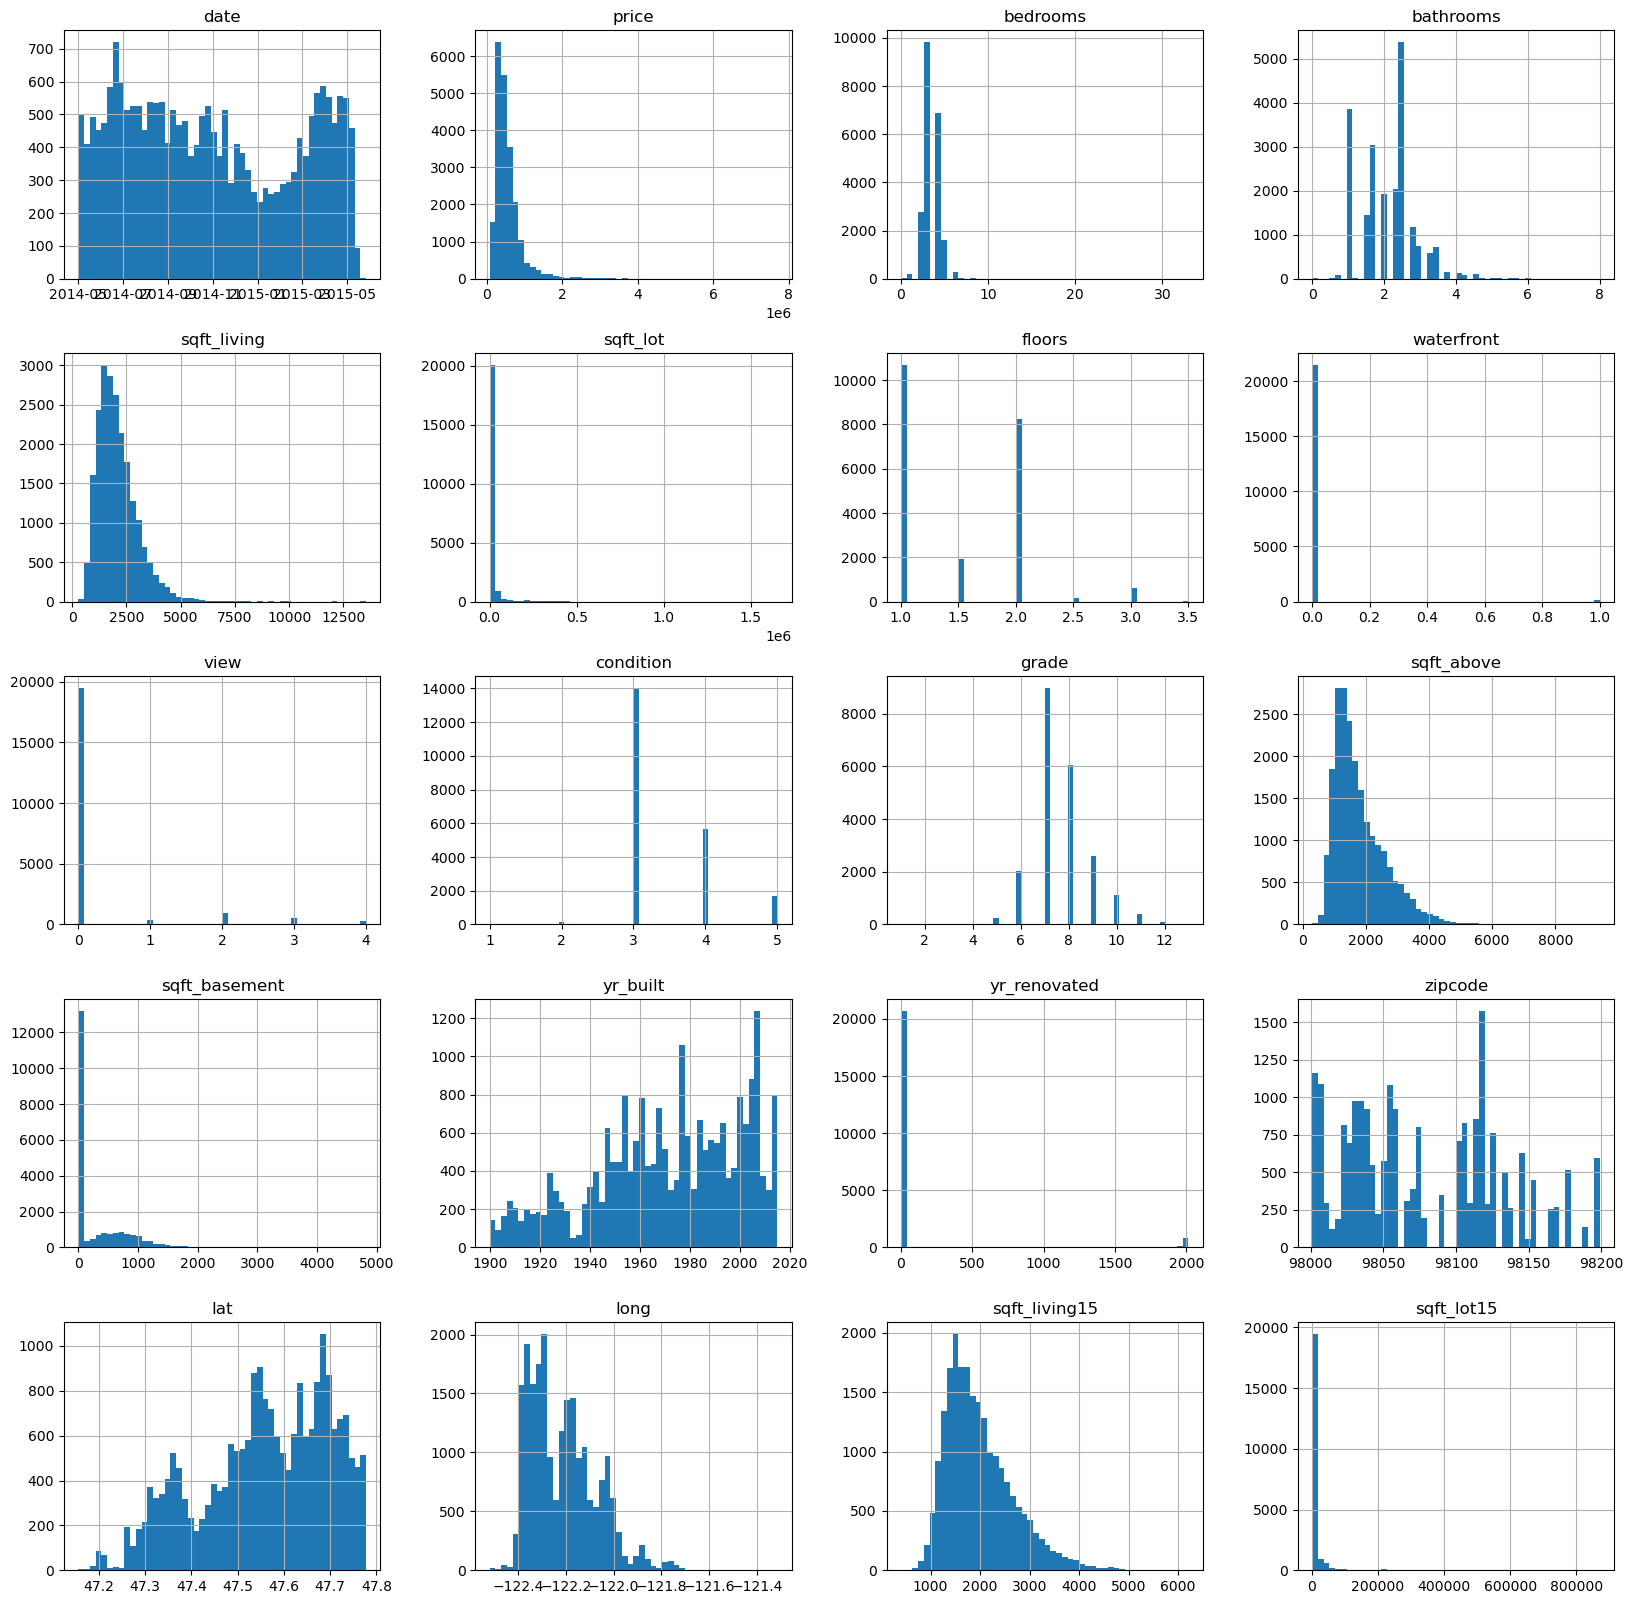

In [7]:
#Display Distribution of Each Value for each column
realestatedata.hist(bins=50, figsize=(20,20))
plt.show()

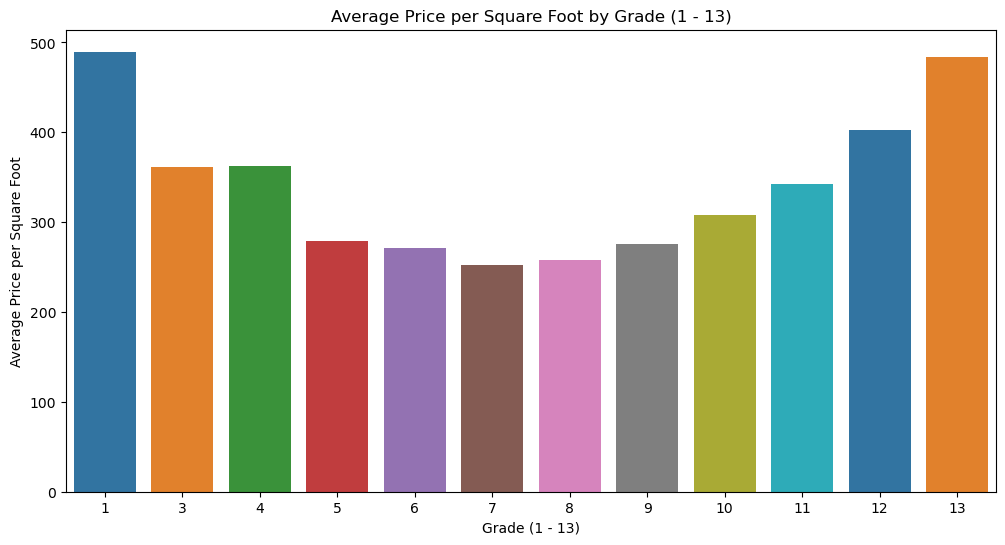

In [69]:
# Created bar plot of household grade to show difference in average price per square foot 
# Created new column 'price_per_sqft' to show how price varies for each grade
realestatedata["price_per_sqft"]=realestatedata["price"]/realestatedata["sqft_living"]
avg_price_per_sqft = realestatedata.groupby('grade')['price_per_sqft'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='grade', y='price_per_sqft', data=avg_price_per_sqft, palette='tab10')
plt.title('Average Price per Square Foot by Grade (1 - 13)')
plt.xlabel('Grade (1 - 13)')
plt.ylabel('Average Price per Square Foot')
plt.show()

In [70]:
#Displaying visual map of each households resale price, SQFT, price per square foot, and zipcode respective to their specific location using latitude and longitude.

seattle_map = folium.Map(location=[47.6062, -122.3321], zoom_start=10)
marker_cluster = MarkerCluster().add_to(seattle_map)
for index, row in realestatedata.iterrows():
    popup_text=f"""
        Price: ${row['price']}
        Household SQFT: {row['sqft_living']}
        Price Per Square Foot: {row['price_per_sqft']}
        Zipcode: {row['zipcode']}
        """
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=folium.Popup(popup_text, max_width=300),
    ).add_to(marker_cluster)
    
heat_data = [[row['lat'], row['long'], row['price']] for index, row in realestatedata.iterrows()]
HeatMap(heat_data, radius=15, blur=25).add_to(seattle_map)

seattle_map.save('seattle_realestate_map_heatmap.html')
from IPython.display import HTML

map_file = 'seattle_realestate_map_heatmap.html'

HTML(f'<iframe src={map_file} width=800 height=600></iframe>')

C:\Users\mrbur\SpringBoard\Lib\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


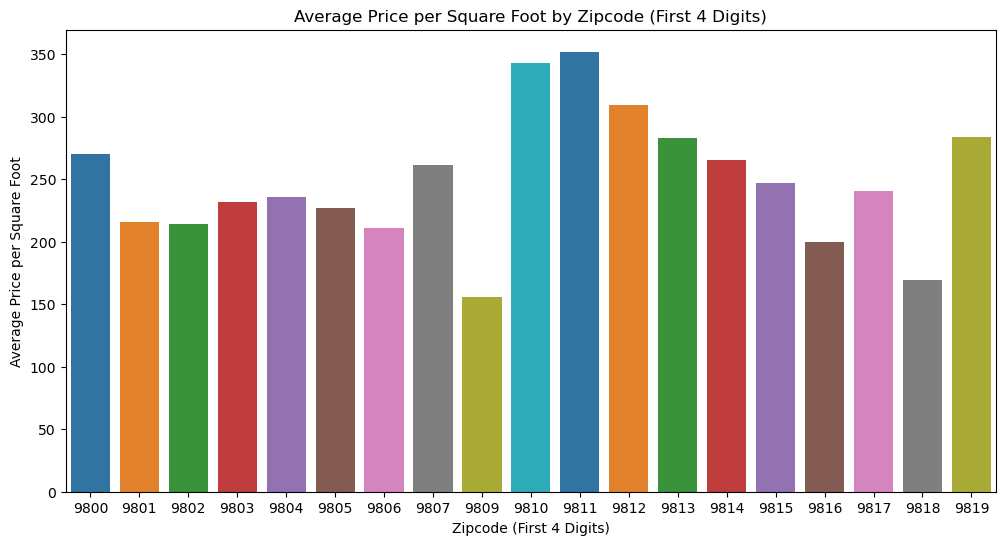

In [10]:
#Displaying average price per square foot by zipcode to see if price differs by neighborhood
realestatedata['zipcode_first4'] = realestatedata['zipcode'].astype(str).str[:4]

avg_price_per_sqft = realestatedata.groupby('zipcode_first4')['price_per_sqft'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='zipcode_first4', y='price_per_sqft', data=avg_price_per_sqft, palette='tab10')
plt.title('Average Price per Square Foot by Zipcode (First 4 Digits)')
plt.xlabel('Zipcode (First 4 Digits)')
plt.ylabel('Average Price per Square Foot')
plt.show()

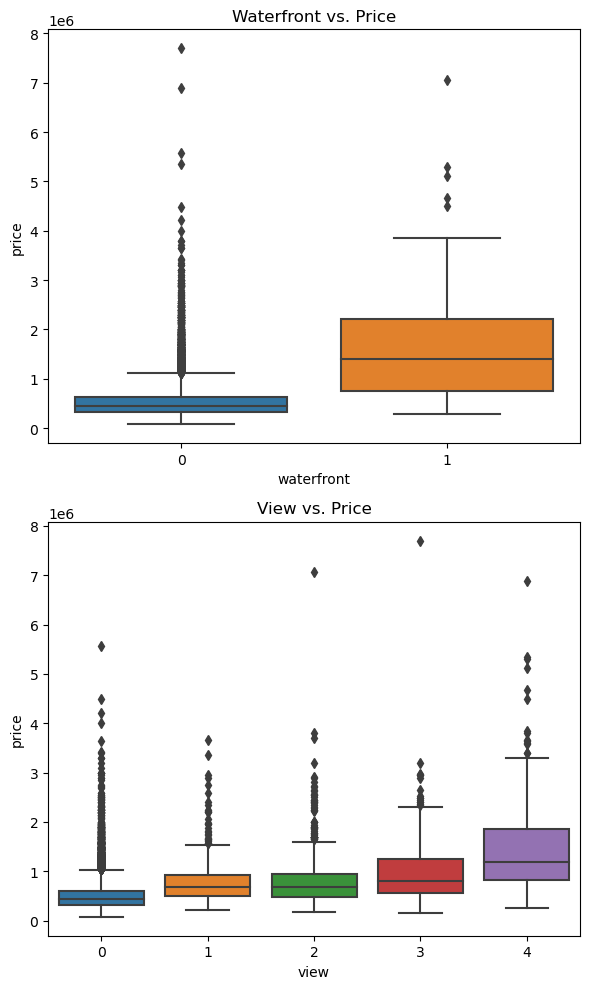

In [11]:
#Distribution of price for households that have a waterfront or views(1-4 amount of views)

plt.figure(figsize=(6, 10)) 

plt.subplot(2, 1, 1)  
sns.boxplot(x='waterfront', y='price', data=realestatedata)
plt.title('Waterfront vs. Price')

plt.subplot(2, 1, 2)  
sns.boxplot(x='view', y='price', data=realestatedata)
plt.title('View vs. Price')

plt.tight_layout()
plt.show()

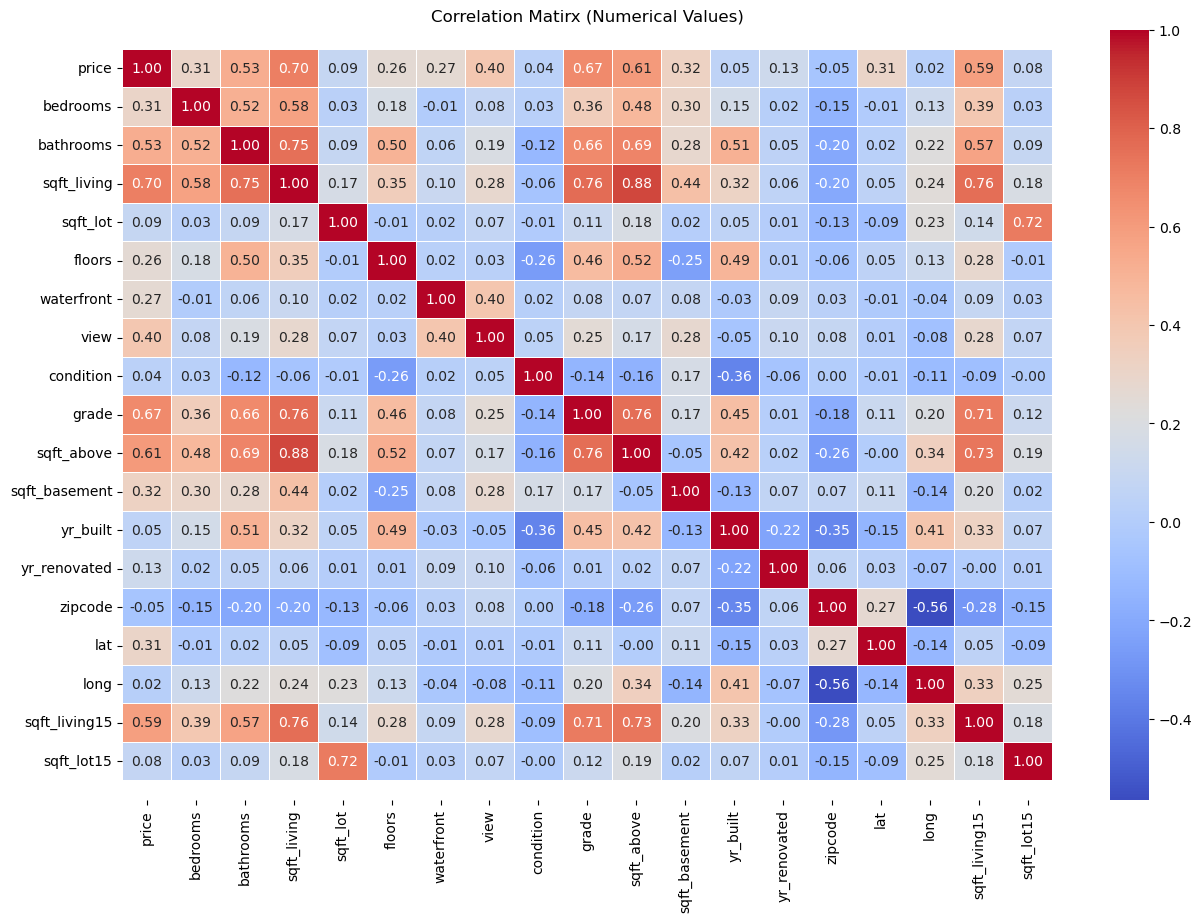

In [64]:
#Determining what factors are negatively or positively correlated with price
numerical_columns = realestatedata.select_dtypes(include=['number'])
corr_matrix = numerical_columns.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix, annot=True,linewidths=0.5,fmt=".2f",cmap="coolwarm", );
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Correlation Matirx (Numerical Values)")
plt.show()

<Axes: title={'center': 'Correlation With Price'}>

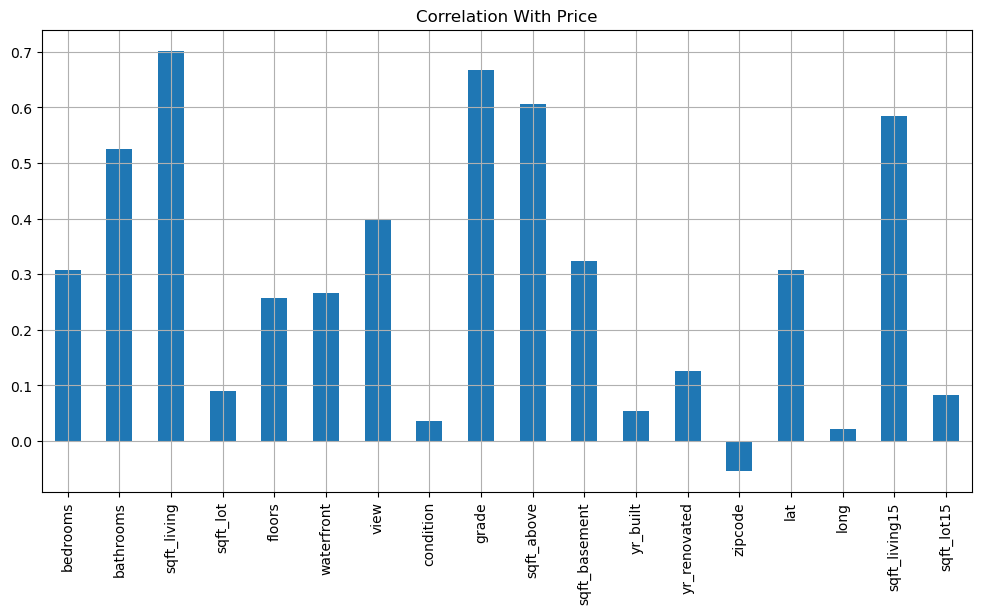

In [65]:
numerical_columns.drop('price',axis=1).corrwith(numerical_columns.price).plot(kind='bar',grid=True,
                                                                             figsize=(12,6),title="Correlation With Price")


In [67]:
# Removing outliers


def remove_outliers_iqr(df, column, k=1.5):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_no_outliers




In [ ]:
X=realestatedata.drop(['price_per_sqft','price'], axis=1)
Y=realestatedata['price_per_sqft']

In [ ]:
#Correcting skewed variables
X['sqft_living'] = np.log(X['sqft_living']+1)
X['sqft_above'] = np.log(X['sqft_above']+1)
X['sqft_living15'] = np.log(X['sqft_living15']+1)
X['sqft_basement'] = np.log(X['sqft_basement']+1)

In [ ]:
# Dropping irrelevant columns
drop_cols = ['yr_renovated','zipcode','lat','long']
X.drop(columns=drop_cols,inplace=True)

In [ ]:
#Created variable age to describe how old a household is
X['age'] = X['date'].dt.year - X['yr_built']

In [ ]:
X.drop(columns=['date','yr_built'],inplace=True)

In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

In [ ]:
# Scaling data
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.fit_transform(X_test)

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = [int(x) for x in np.arange(1, 11)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
# Use the random grid to search for best hyperparameters

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_


In [61]:
# Modeling 
def evaluate(rf, X_test, y_test):
    predictions = rf.predict(X_test)
    mse = mean_squared_error(y_test,predictions)
    rmse = mean_squared_error(y_test,predictions,squared=False)
    mae = mean_absolute_error(y_test,predictions)
    r2 = r2_score(y_test,predictions)

    print('Model Performance')
    print('RMSE: {:0.4f} degrees.'.format(rmse))
    print('MSE = {:0.2f}.'.format(mse))
    print('mae = {:0.2f}.'.format(mae))
    print('r2 = {:0.2f}.'.format(r2))

#best_random = GradientBoostingRegressor()
#best_random = XGBRegressor()
best_random = rf_random.best_estimator_
best_random.fit(X_train, y_train)
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
RMSE: 70.6614 degrees.
MSE = 4993.03.
mae = 50.26.
r2 = 0.59.


In [ ]:
# -- xgboost
#Model Performance
#RMSE: 100.9660 degrees.
#MSE = 10194.14.
#mae = 75.15.
#r2 = 0.17.


# -- gradient boost--
#Model Performance
#RMSE: 80.8874 degrees.
#MSE = 6542.78.
#mae = 60.76.
#r2 = 0.46.

# -- Random Forrest Best Estimator--
#Model Performance
#RMSE: 70.6785 degrees.
#MSE = 4995.45.
#mae = 50.27.
#r2 = 0.59.